In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mb_size = 64
transform = transforms.ToTensor()
train_data=torchvision.datasets.MNIST(root='E:/Coursera-GANS/',train=True,download=True,transform=transform)
trainLoader=torch.utils.data.DataLoader(train_data,batch_size=mb_size,shuffle=True)


9913344it [00:01, 7260041.39it/s]                             


Extracting E:/Coursera-GANS/MNIST\raw\train-images-idx3-ubyte.gz to E:/Coursera-GANS/MNIST\raw



29696it [00:00, 1050096.55it/s]          


Extracting E:/Coursera-GANS/MNIST\raw\train-labels-idx1-ubyte.gz to E:/Coursera-GANS/MNIST\raw



1649664it [00:00, 8090815.17it/s]                             


Extracting E:/Coursera-GANS/MNIST\raw\t10k-images-idx3-ubyte.gz to E:/Coursera-GANS/MNIST\raw



5120it [00:00, 2568453.11it/s]          
C:\PythonEnvironments\TorchEnv\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting E:/Coursera-GANS/MNIST\raw\t10k-labels-idx1-ubyte.gz to E:/Coursera-GANS/MNIST\raw

Processing...
Done!


In [4]:
dataIterator=iter(trainLoader)
imgs,labels=dataIterator.next()

In [6]:
imgs.shape

torch.Size([64, 1, 28, 28])

In [53]:
def imshow(imgs):
    imgs=torchvision.utils.make_grid(imgs).to('cpu')

    npimgs=imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs,(1,2,0)),cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

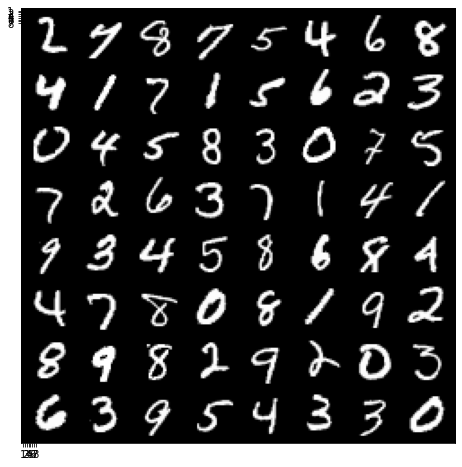

In [10]:
imshow(imgs)

In [45]:
#zeros=np.zeros((64,1,28,28))
#transposed=np.transpose(zeros,(1,2,0,3))
#transposed.shape
device = 'cuda'

In [46]:
Z_dim=100
H_dim=128
X_dim=imgs.view(imgs.size(0),-1).size(1)
print(Z_dim,H_dim,X_dim)

100 128 784


In [47]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(Z_dim,H_dim),
            nn.ReLU(),
            nn.Linear(H_dim,X_dim),
            nn.Sigmoid()    
        )
    def forward(self,input):
        return self.model(input)

In [48]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(X_dim,H_dim),
            nn.ReLU(),
            nn.Linear(H_dim,1),
            nn.Sigmoid()
        )
    def forward(self,input):    
        return self.model(input)


In [49]:
D=Dis().to(device)
G=Gen().to(device)


In [50]:
lr=0.001
g_opt=opt.Adam(G.parameters(),lr=lr)
d_opt=opt.Adam(D.parameters(),lr=lr)


In [51]:
def get_noise(mb_size,Z_dim):
    return torch.randn(mb_size,Z_dim).to(device)


Epoch:0,   G_loss:2.6761372314333154,    D_loss:0.3612510406418141


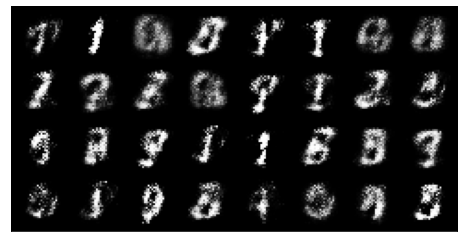

Epoch:1,   G_loss:2.6166225934841996,    D_loss:0.3915471567400991


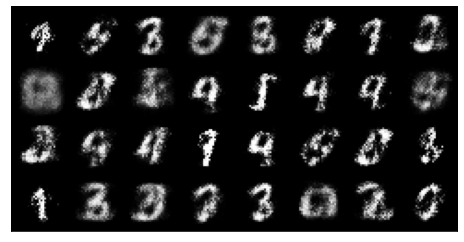

Epoch:2,   G_loss:2.478421032810008,    D_loss:0.4196763139511985


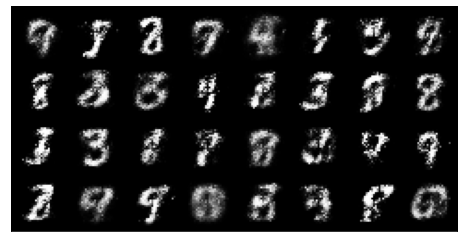

Epoch:3,   G_loss:2.4207798362032436,    D_loss:0.4551540605549111


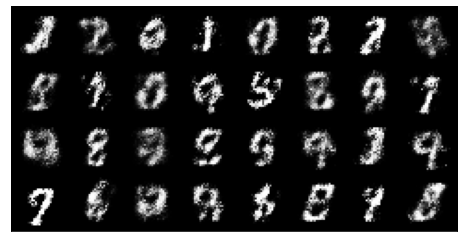

In [55]:
for epoch in range(4):
    G_loss_run=0.0
    D_loss_run=0.0
    for i,data in enumerate(trainLoader):
        x,_=data
        x=x.view(x.size(0),-1).to(device)
        mb_size=x.size(0)
        one_labels=torch.ones(mb_size,1).to(device)
        zero_labels=torch.zeros(mb_size,1).to(device)

        z=get_noise(mb_size,Z_dim)

        D_real=D(x)
        D_fake=D(G(z))

        D_real_loss=F.binary_cross_entropy(D_real,one_labels)
        D_fake_loss=F.binary_cross_entropy(D_fake,zero_labels)

        D_loss=0.5*(D_real_loss+D_fake_loss)

        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()

        z=get_noise(mb_size,Z_dim)
        D_fake=D(G(z))
        G_loss=F.binary_cross_entropy(D_fake,one_labels)

        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()

        G_loss_run+=G_loss.item()
        D_loss_run+=D_loss.item()

    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    sample=G(z).detach()
    samples=sample.view(sample.size(0),1,28,28)
    imshow(samples)
        
